# TP : Word Embeddings for Classification

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [309]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [310]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

rncp.head()

,Categorie,text_certifications
0,1,Responsable de chantiers de bûcheronnage manue...
1,1,Responsable de chantiers de bûcheronnage manue...
2,1,Travaux forestiers
3,1,Forêt
4,1,Forêt


In [311]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [312]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [313]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [314]:
# split the data in training and test sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [349]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 100
texts_reduced = train_texts[0::k]
labels_reduced = train_labels[0::k]

# check if there are NaN values
print('Number of NaN values in the texts:', np.sum(pd.isnull(texts_reduced)))
print('Number of NaN values in the labels:', np.sum(pd.isnull(labels_reduced)))

print('Number of documents:', len(texts_reduced))

Number of NaN values in the texts: 0
Number of NaN values in the labels: 0
Number of documents: 755


## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [316]:
!pip install git+https://github.com/ClaudeCoulombe/FrenchLefffLemmatizer.git >nul 2>&1

In [317]:
!pip install nltk


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [318]:
# Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<div class='alert alert-block alert-info'>
            Code:</div>

In [319]:
# Look at the data and apply the appropriate pre-processing

def preprocess_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove everything except alphanumeric characters and diacritics
    text = re.sub(r'[^\w\sÀ-ÿ]', ' ', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('french'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize words (reduce them to their root form)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

# Test the function
for texts in [train_texts[:5], test_texts[:5]]:
    for text in texts:
        print(text)
        print(preprocess_text(text))
    print()

Architecte d'interieur/designer
['architecte', 'interieur', 'designer']
Ingénierie Nucléaire
['ingénierie', 'nucléaire']
Métiers du Multimédia et de l’Internet : Développement web et dispositifs interactifs
['métiers', 'multimédia', 'internet', 'développement', 'web', 'dispositifs', 'interactifs']
STAPS : Ingénierie et ergonomie de l'activité physique (IEAP)(fiche nationale)
['staps', 'ingénierie', 'ergonomie', 'activité', 'physique', 'ieap', 'fiche', 'nationale']
Programme TEMA (Innovation & Digital Management), visé par le Ministère de l’Enseignement Supérieur et de la Recherche
['programme', 'tema', 'innovation', 'digital', 'management', 'visé', 'ministère', 'enseignement', 'supérieur', 'recherche']

Domaine : Sciences Technologies Santé Mention : Maintenance des systèmes pluritechniques - Spécialité : Management des services de maintenance
['domaine', 'science', 'technology', 'santé', 'mention', 'maintenance', 'systèmes', 'pluritechniques', 'spécialité', 'management', 'service', 'm

In [357]:
# Look at the data and apply the appropriate pre-processing

texts_processed = []
for i, t in enumerate(train_texts):
    # Print a few examples
    if 10 < i < 15:
        print("Sample text:")
        print("\t", t)
        print("Is changed to:")
        print("\t", preprocess_text(t))
        print("-----------------------------------")
    # Apply the pre-processing to all texts
    texts_processed.append(preprocess_text(t))

test_texts_processed = [preprocess_text(t) for t in test_texts]

Sample text:
	 Sociologie spécialité Recherche, étude, conseil et interventions en sociologie(RECIS)
Is changed to:
	 ['sociologie', 'spécialité', 'recherche', 'étude', 'conseil', 'intervention', 'sociologie', 'recis']
-----------------------------------
Sample text:
	 Manager du développement international mode et luxe
Is changed to:
	 ['manager', 'développement', 'international', 'mode', 'luxe']
-----------------------------------
Sample text:
	 mention Droit des Affaires
Is changed to:
	 ['mention', 'droit', 'affaire']
-----------------------------------
Sample text:
	 Manager en projets internationaux
Is changed to:
	 ['manager', 'projets', 'internationaux']
-----------------------------------


Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [320]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    words = []
    for text in texts:
        text = preprocess_text(text)
        words += text
    vocabularySet = set(words)
    vocabulary = dict(zip(list(vocabularySet),np.arange(len(vocabularySet))))
    
    counts = np.zeros((len(texts), len(vocabularySet) ), dtype=int)
    for k, text in enumerate(texts):
        for word in preprocess_text(text):
            counts[k,vocabulary[word]] += 1
    
    
    word_freq = {}
    for k, text in enumerate(texts):
        for word in preprocess_text(text):
            counts[k,vocabulary[word]] += 1
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    return vocabulary, counts, word_freq

In [359]:
# Now preprocessed_texts contains the preprocessed versions of the first 5 texts from train_texts and test_texts
vocabulary, counts, word_counts = count_words(texts_reduced)

# check if there are NaN values


print(len(vocabulary))
print(f'Length of vocabulary: {len(vocabulary)}')
print(f'Vocabulary: {list(vocabulary.keys())[:10]}...')
print(f'Counts shape: {counts.shape}')
print('Counts contains the number of occurences of each word in the vocabulary for each text in the training set.')

word_counts

1068
Length of vocabulary: 1068
Vocabulary: ['costo', 'organisation', 'scientifiques', 'montbéliard', 'spé', 'responsable', 'ère', 'qualiticien', 'fondements', 'biocœur']...
Counts shape: (755, 1068)
Counts contains the number of occurences of each word in the vocabulary for each text in the training set.


{'architecte': 1,
 'interieur': 1,
 'designer': 1,
 'domaine': 84,
 'science': 231,
 'humaines': 39,
 'sociales': 36,
 'mention': 234,
 'sociologie': 6,
 'spécialité': 307,
 'enjeux': 1,
 'pratiques': 2,
 'développement': 47,
 'pay': 2,
 'sud': 1,
 'ingénieur': 92,
 'institut': 33,
 'technique': 28,
 'yvelines': 1,
 'isty': 1,
 'uvsq': 1,
 'université': 39,
 'paris': 11,
 'saclay': 1,
 'systèmes': 40,
 'numériques': 6,
 'industrie': 10,
 'biologie': 25,
 'santé': 126,
 'ergonomie': 5,
 'ingénierie': 37,
 'facteurs': 1,
 'humains': 1,
 'éducation': 7,
 'formation': 8,
 'technicien': 16,
 'supérieur': 16,
 'qualité': 17,
 'hygiène': 5,
 'environnement': 40,
 'sécurité': 23,
 'droit': 82,
 'economie': 32,
 'gestion': 90,
 'chef': 14,
 'équipe': 1,
 'interprétation': 4,
 'analyse': 4,
 'image': 6,
 'licence': 16,
 'professionnelle': 54,
 'production': 33,
 'animales': 3,
 'aquaculture': 2,
 'continentale': 1,
 'aquariologie': 1,
 'métiers': 33,
 'édition': 1,
 'option': 36,
 'librairie': 1

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Question:</div>

## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [351]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Create a count vectorizer with the vocabulary
count_vectorizer = CountVectorizer(vocabulary=vocabulary)
# Fit the vectorizer to the training data
texts_vectorized = count_vectorizer.transform(texts_processed)
# Transform the test data
test_texts_vectorized = count_vectorizer.transform(test_texts_processed)

# Create a logistic regression model and fit it to the training data
model_count = LogisticRegression(max_iter=10_000)
model_count.fit(texts_vectorized, train_labels)
# Predict the test data
model_count_pred = model_count.predict(test_texts_vectorized)

# Calculate the confusion matrix
conf_mat = confusion_matrix(test_labels, model_count_pred)

Number of NaN values in the training set: 0
Number of NaN values in the test set: 0


In [323]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Assuming y_train is your array of labels for the training data
model = LogisticRegression(max_iter=1000)
model.fit(X_train, labels_reduced)

# Now you can use the model to make predictions on your test data
predictions = model.predict(X_test)

# evaluate the model

accuracy = accuracy_score(test_labels, predictions)

print('Accuracy:', accuracy)

Accuracy: 0.2073371149870116


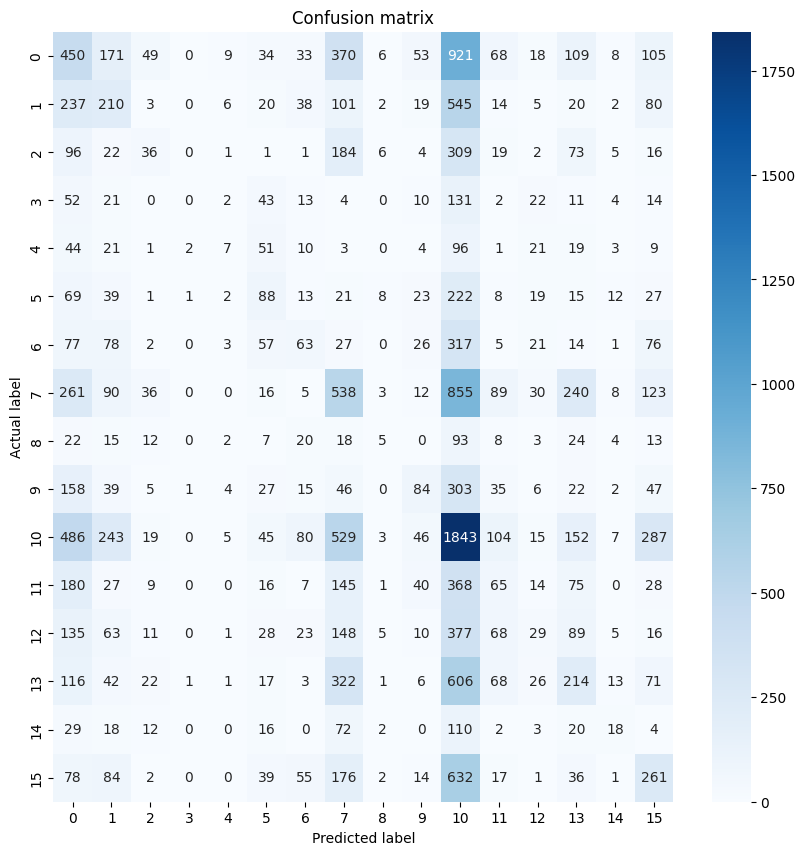

In [324]:
# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

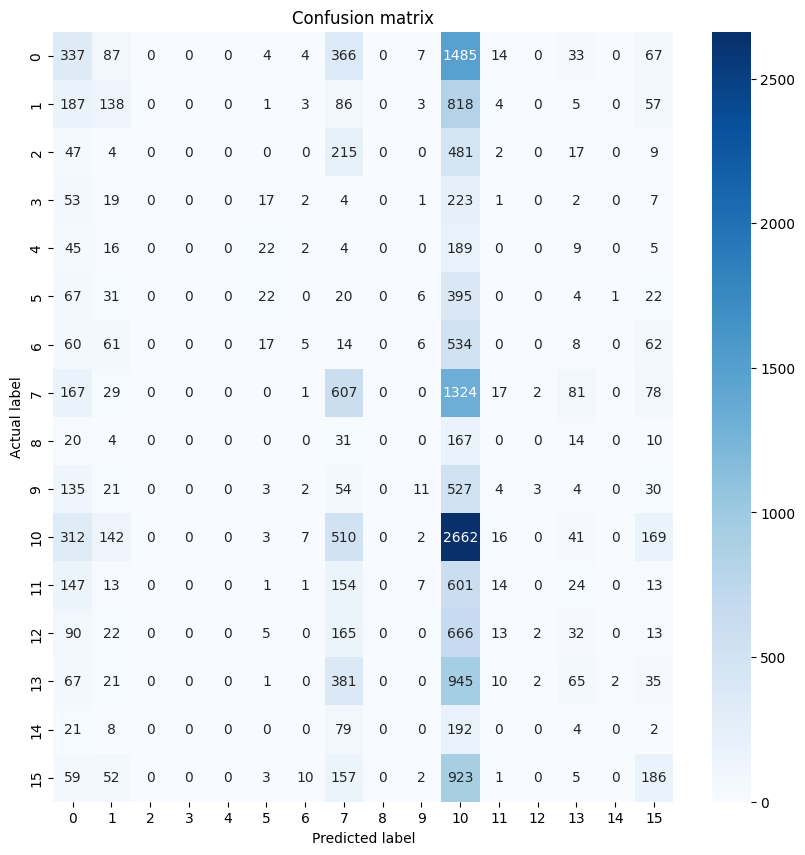

In [325]:
import matplotlib.pyplot as plt
import seaborn as sns

# TfidfVectorizer
vectorizer = TfidfVectorizer(vocabulary=vocabulary)
X_train = vectorizer.fit_transform(texts_reduced)
X_test = vectorizer.transform(test_texts)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, labels_reduced)

predictions = model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

[[ 311   84    0    0    0    3    4  372    0    6 1517   13    0   33
     0   61]
 [ 185  126    0    0    0    1    2   84    0    2  842    4    0    2
     0   54]
 [  42    4    0    0    0    0    0  213    0    0  490    2    0   17
     0    7]
 [  59   17    0    0    0    7    0    4    0    1  229    0    0    6
     0    6]
 [  41   14    0    0    0   15    2    4    0    0  200    0    0    9
     0    7]
 [  65   30    0    0    0   17    1   22    0    6  400    0    0    5
     1   21]
 [  57   57    0    0    0   12    9   15    0    6  539    1    0    8
     0   63]
 [ 141   25    0    0    0    0    0  618    0    0 1355   14    2   76
     0   75]
 [  21    6    0    0    0    0    0   31    0    0  172    0    0    7
     0    9]
 [ 130   14    0    0    0    1    1   53    0   10  544    5    3    5
     0   28]
 [ 257  121    0    0    0    0   13  512    0    1 2763   13    0   32
     0  152]
 [ 127    9    0    0    0    0    1  161    0    6  621   14    

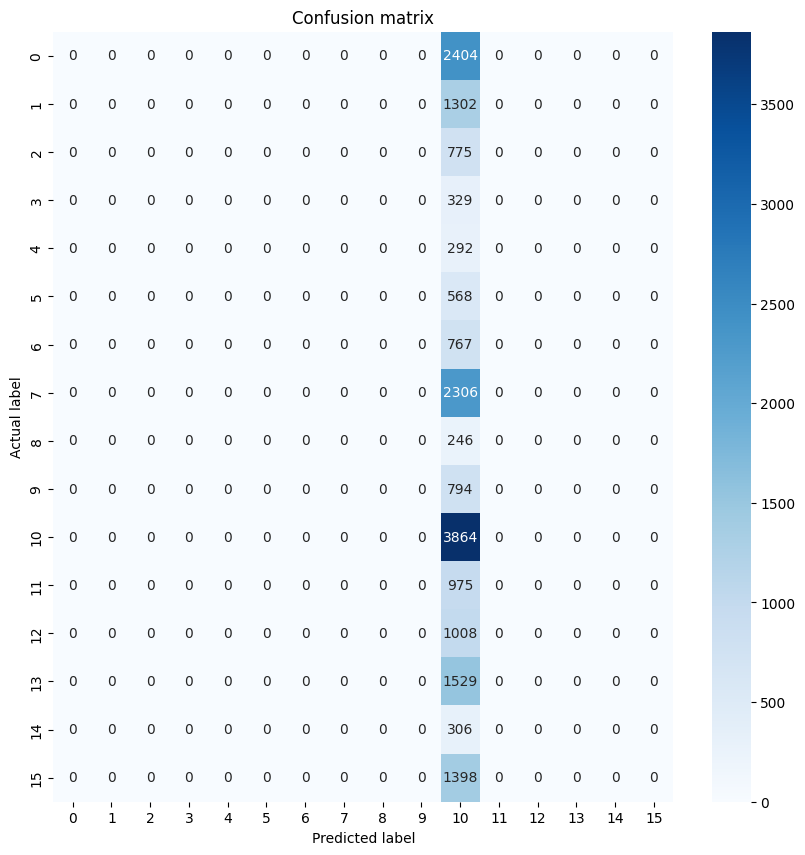

In [326]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

# Number of topics
n_topics = 300

# TruncatedSVD
svd = TruncatedSVD(n_components=n_topics)
X_train_svd = svd.fit_transform(X_train)
X_test_svd = svd.transform(X_test)

model = LogisticRegression(max_iter=1000)    
model.fit(X_train_svd, labels_reduced)

predictions = model.predict(X_test_svd)
print(confusion_matrix(test_labels, predictions))

# LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
X_train_lda = lda.fit_transform(X_train)
X_test_lda = lda.transform(X_test)

model = LogisticRegression()
model.fit(X_train_lda, labels_reduced)

predictions = model.predict(X_test_lda)

cm = confusion_matrix(test_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [327]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Get the sentence
        vocabulary = {word: idx for idx, word in enumerate(vocabulary)}
        sent = [word for word in sent if word in vocabulary]
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary[word] for word in sent]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
            sent_idx.append(len(vocabulary)-1) # This adds an Unknown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i-window):i]                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1 / abs(i-j)
                M[ctx_idx, idx] += 1 / abs(i-j)
    return M

<div class='alert alert-block alert-info'>
            Code:</div>

In [352]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension
M = co_occurence_matrix(texts_reduced, vocabulary, window=5)
M

# check if there are NaN values
print('Number of NaN values in the co-occurence matrix:', np.sum(np.isnan(M)))

Number of NaN values in the co-occurence matrix: 0


In [353]:
# Truncate using truncated svd
svd = TruncatedSVD(n_components=300)
M_svd = svd.fit_transform(M)

# check if there are NaN values
print('Number of NaN values in the truncated co-occurence matrix:', np.sum(np.isnan(M_svd)))


Number of NaN values in the truncated co-occurence matrix: 0


<div class='alert alert-block alert-info'>
            Code:</div>

In [354]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        # Indexes of words in the sentence obtained thanks to the vocabulary
        indexes = [vocabulary[x] if x in vocabulary else vocabulary["UNK"] 
                   for x in text.split(" ")]  
        # Embeddings of words in the sentence, aggregated thanks to the function
        sentrep = np_func(np.array([embeddings[index, :]
                    for index in indexes]), axis=0)
        representations.append(sentrep)
        
    representations = np.array(representations)
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [358]:
# Obtain document representations, apply the classifier

train_representations = sentence_representations(texts_processed, vocabulary, M_svd)
test_representations = sentence_representations(test_texts, vocabulary, M_svd)

AttributeError: 'list' object has no attribute 'split'

In [347]:
X_train


num_nan = np.isnan(X_train).sum()
print(f'The number of NaN values in X_train is {num_nan}')

X_test
num_nan = np.isnan(X_test).sum()
print(f'The number of NaN values in X_test is {num_nan}')

The number of NaN values in X_train is 1200
The number of NaN values in X_test is 27600


In [348]:
from sklearn.impute import SimpleImputer
import numpy as np

# Initialize the imputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit the imputer and transform the data
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Train the classifier with the imputed data
clf.fit(X_train_imputed, labels_reduced)

# Use the trained classifier to predict labels for the test data
y_pred = clf.predict(X_test_imputed)

y_pred.shape

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(18863,)

In [342]:
from sklearn.metrics import accuracy_score

# Assuming y_test are the true labels of the test data
accuracy = accuracy_score(test_texts, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.0


## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [335]:
!pip install gensim


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [336]:
from gensim.models import Word2Vec

In [337]:
model = Word2Vec(vector_size=300,
                 window=5,
                 null_word=len(word_counts))
model.build_vocab_from_freq(word_counts)

<div class='alert alert-block alert-info'>
            Code:</div>

In [338]:
# The model is to be trained with a list of tokenized sentences, containing the full training dataset.

import nltk
nltk.download('punkt')

def tokenize(sentence):
    return nltk.word_tokenize(sentence)

preprocessed_corpus = [tokenize(sentence) for sentence in texts_reduced]



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [339]:
preprocessed_corpus

[['Architecte', "d'interieur/designer"],
 ['Domaine',
  'Sciences',
  'Humaines',
  'et',
  'Sociales',
  ',',
  'Mention',
  'Sociologie',
  ',',
  'Spécialité',
  'Enjeux',
  'et',
  'Pratiques',
  'de',
  'Développement',
  'dans',
  'les',
  'Pays',
  'du',
  'Sud',
  '.'],
 ['Ingénieur',
  'de',
  'l',
  '’',
  'Institut',
  'des',
  'Sciences',
  'et',
  'Techniques',
  'des',
  'Yvelines',
  '(',
  'ISTY',
  ')',
  'de',
  'l',
  '’',
  'UVSQ',
  'Université',
  'Paris-Saclay',
  ',',
  'Spécialité',
  '«',
  'Systèmes',
  'Numériques',
  'pour',
  'l',
  '’',
  'industrie',
  '»'],
 ['BIOLOGIE',
  'et',
  'SANTÉ',
  ',',
  'spécialité',
  'ERGONOMIE',
  ',',
  'INGÉNIERIE',
  'DE',
  'LA',
  'SANTÉ',
  'ET',
  'DES',
  'FACTEURS',
  'HUMAINS'],
 ['Domaine',
  ':',
  'Sciences',
  'humaines',
  'et',
  'sociales',
  'Mention',
  ':',
  'Éducation',
  'et',
  'formation',
  'Spécialité',
  ':',
  'Sciences',
  'humaines',
  'pour',
  'l',
  '’',
  'éducation'],
 ['Technicien',
  

In [340]:
model.train(preprocessed_corpus, total_examples=len(preprocessed_corpus), epochs=30, report_delay=1)

(27209, 265860)

In [341]:
# Generate predictions on the test dataset
predictions = model.predict(X_test)

# Compare the predictions to the actual values
accuracy = sum(predictions == test_labels) / len(test_labels)

print(f"Accuracy: {accuracy * 100}%")

AttributeError: 'Word2Vec' object has no attribute 'predict'

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 